# 5. Repetição do treinamento e testes da primeira CNN

Neste quinto notebook, será avaliado o impacto da alteração de distribuição de classes, feita no notebook 4, no primeiro modelo desenvolvido no notebook 3. Com isso, será esperada uma diminuição do viés na etapa de testes. Os resultados obtidos serão discutidos no final do notebook.

In [1]:
# Importacao bibliotecas
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import json
import os
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Caminho utilizados para acessar ou enviar arquivos

caminho_imagens_treinamento = "/home/giovanni/Projetos/Local/TCC/Datasets/Recortes_Subamostrados/Treinamento"
caminho_imagens_teste = "/home/giovanni/Projetos/Local/TCC/Datasets/Recortes_Subamostrados/Teste"
caminho_rotulos_treinamento = "/home/giovanni/Projetos/Local/TCC/Datasets/Recortes_Subamostrados/rotulos_balanceados_regioes_treinamento.json"
caminho_rotulos_teste = "/home/giovanni/Projetos/Local/TCC/Datasets/Recortes_Subamostrados/rotulos_balanceados_regioes_teste.json"

## 5.1. Definição de arquitetura

In [3]:
# Primeira arquitetura de CNN
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 6 * 6, 512)  # Atualizado para acomodar entrada de 50x50
        self.fc2 = nn.Linear(512, num_classes) # 3 classes de classificacao: No issues, Broken, Flashover damage

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 6 * 6)  # Acomodar entrada de 50x50
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Dataset personalizado
class CustomDataset(Dataset):
    def __init__(self, data_path, image_path, transform=None):
        self.data = json.load(open(data_path))
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data[idx]['nome']
        img_class = self.data[idx]['classificacao']
        path = os.path.join(self.image_path, img_name)
        
        try:
            img = Image.open(path).convert('RGB')
            img = img.resize((50, 50))  # Redimensiona para 50x50
        except FileNotFoundError:
            print(f'Arquivo de imagem não encontrado: {path}. Pulando esta imagem.')
            # Retornar uma imagem vazia e um rótulo inválido
            return torch.zeros(3, 50, 50), -1
        
        if self.transform:
            img = self.transform(img)
        
        # Converter o rótulo para um índice numérico
        class_to_index = {"No issues": 0, "Flashover damage": 1, "Broken": 2}
        if img_class in class_to_index:
            img_class = class_to_index[img_class]
        else:
            img_class = -1  # Definir como um rótulo inválido
        
        return img, img_class

## 5.2. Avaliação do Modelo

In [5]:
# Funcao para calcular a acurácia, recall, F1-score e matriz de confusão
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            
            if isinstance(labels, tuple):
                # Verificar se o rótulo é uma tupla vazia (indicando que é inválido)
                if len(labels) == 0:
                    continue  # Pular esta iteração se o rótulo for inválido
                labels = labels[0]  # Extrair o rótulo válido da tupla
            
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, recall, f1, cm

## 5.3. Plot dos Resultados

In [6]:
# Função para plotar a função de perda durante o treinamento
def plot_loss(loss_values):
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

# Função para plotar a matriz de confusão
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 5.4. Carregamento das bases de teste e treinamento

In [7]:
# Carregar dados de treinamento e teste
train_data = CustomDataset(caminho_rotulos_treinamento, caminho_imagens_treinamento, transform=transforms.ToTensor())
test_data = CustomDataset(caminho_rotulos_teste, caminho_imagens_teste, transform=transforms.ToTensor())

In [8]:
# Definição de hiperparâmetros
batch_size = 16
learning_rate = 0.001
num_epochs = 10

# DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Verificar se a GPU está disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instanciar o modelo e mover para GPU, se disponível
model = CNN().to(device)

# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lista para armazenar os valores da função de perda durante o treinamento
loss_values = []

# Mapear classes de string para índices numéricos
class_to_index = {"No issues": 0, "Flashover damage": 1, "Broken": 2}

## 5.5. Treinamento do modelo

In [9]:
# Treinamento do modelo
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

Epoch [1/10], Loss: 0.9127443659044531
Epoch [2/10], Loss: 0.8361603389256191
Epoch [3/10], Loss: 0.7909928911938865
Epoch [4/10], Loss: 0.724586484713566
Epoch [5/10], Loss: 0.6498561222332817
Epoch [6/10], Loss: 0.5735965168461602
Epoch [7/10], Loss: 0.498356125850022
Epoch [8/10], Loss: 0.4211408589986989
Epoch [9/10], Loss: 0.33904013585145165
Epoch [10/10], Loss: 0.2880451299449533


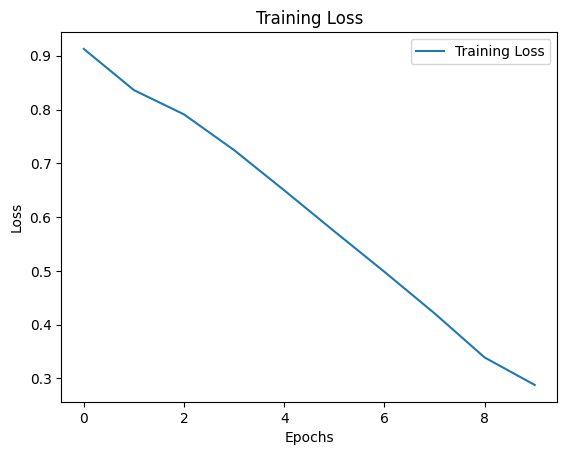

In [10]:
# Plotar a função de perda durante o treinamento
plot_loss(loss_values)

## 5.6. Avaliação do modelo

1. Precisão: **69,43 %**
2. Recall: **69,43 %**
3. F1-score: **69,37 %**

In [11]:
# Avaliação do modelo
accuracy, recall, f1, cm = evaluate_model(model, test_loader)
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(cm)

Accuracy: 0.694375
Recall: 0.694375
F1-score: 0.6937290969532891
Confusion Matrix:
[[631 152  65]
 [182 314  17]
 [ 49  24 166]]


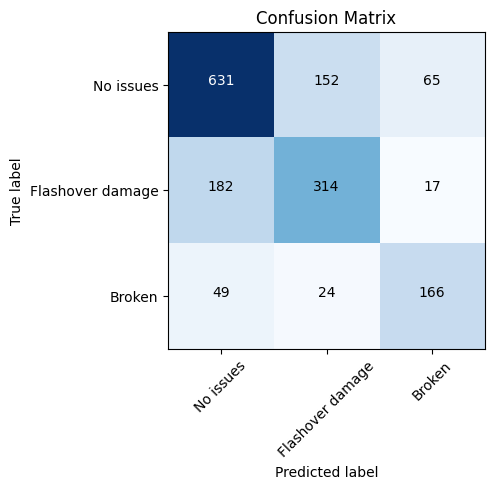

In [12]:
# Plotar a matriz de confusão
plot_confusion_matrix(cm, classes=['No issues', 'Flashover damage', 'Broken'])

### Distribuição de classes do conjunto de teste

* No issues: 848 amostras
* Flashover damage: 513 amostras
* Broken: 239 amostras

### Precisão de acerto de classificação sobre cada classe
* No issues: 631 acertos / 848 amostras = **74,4% de acerto**
* Flashover damage: 314 acertos / 513 amostras = **61,2% de acerto**
* Broken: 166 acertos / 239 amostras = **69,4% de acerto**

### Conclusões a respeito da segunda tentativa:
* Após a diminuição da classe dominante de discos intactos, foi observado uma melhoria **muito significativa** no acerto das classes de discos quebrados, sobretudo de **Flashover damage**.
* Após solucionarmos a questão do viés no treinamento e teste da rede, será feito agora um aumento na distribuição das classes de discos quebrados.